# 6. Quantum Phase Estimation vs. Hadamard Test

In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Table of Contents
* [Hadamard Test Simulation](#HTsim)
* [Hadamard Test Quantum Computer](#HTqc)
* [Quantum Phase Estimation Simulation](#QPEsim)
* [Quantum Phase Estimation Quantum Computer](#QPEqc)

## Hadamard Test Simulation <a name="HTsim"></a>

In [15]:
angle = 1/3 #Exact value of phi to estimate
angle = angle%(2*pi)
print("Angle: ",angle, "rad")

Angle:  0.3333333333333333 rad


In [16]:
def re_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0$\u27e9')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9') 
    circuit.cp(2*pi*theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_2$\u27e9') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

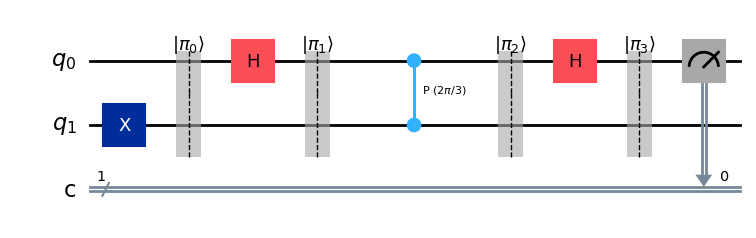

In [17]:
HTre = re_HT(angle)
HTre.draw('mpl')

In [18]:
def im_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0\u27e9$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9')
    circuit.s(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$|π_2$\u27e9')
    circuit.cp(2*pi*theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_4$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

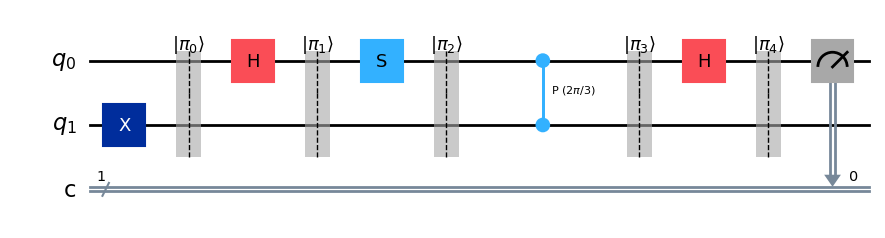

In [19]:
HTim = im_HT(angle)
HTim.draw('mpl')

In [20]:
sim = AerSimulator() # set simulator
shots = 1000

In [21]:
transRe = transpile(HTre, sim) # transpile real hadamard test circuit
resultRe = sim.run(transRe, shots = shots).result() # run transpiled circuit
countsRe = resultRe.get_counts() # retreive counts after measurement

transIm = transpile(HTim, sim) # transpile imaginary hadamard test circuit
resultIm = sim.run(transIm, shots = shots).result() # run transpiled circuit
countsIm = resultIm.get_counts() # retreive counts after measurement

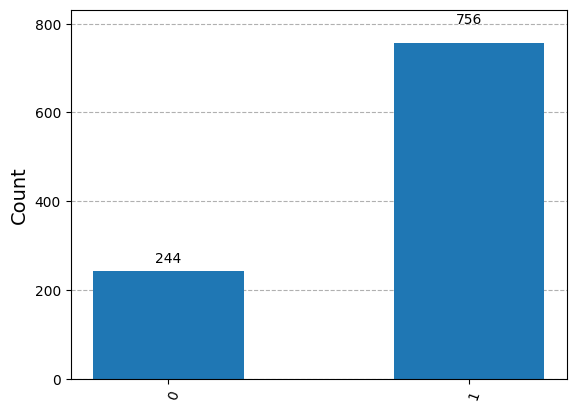

In [22]:
plot_histogram(countsRe)

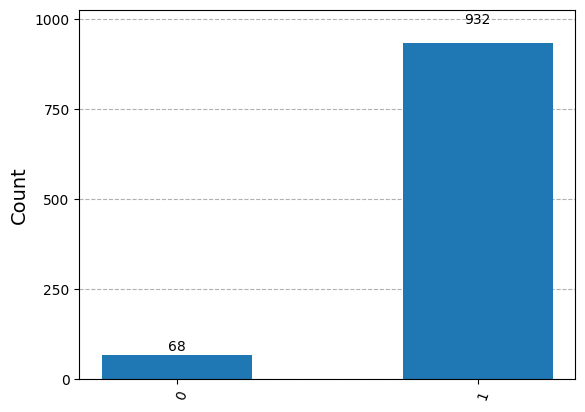

In [23]:
plot_histogram(countsIm)

In [26]:
equation_number = 1 # use cosine to determine angle and sine to determine sign
# equation_number = 2 # use sine to determine angle and cosine to determine sign
# equation_number = 3 # use tan to determine angle
re_p0 = re_p1 = im_p0 = im_p1 = 0

if countsRe.get('0') is not None:
    re_p0 = countsRe['0']/shots
    
if countsRe.get('1') is not None:
    re_p1 = countsRe['1']/shots
    
if countsIm.get('0') is not None:
    im_p0 = countsIm['0']/shots
    
if countsIm.get('1') is not None:
    im_p1 = countsIm['1']/shots

re = re_p0 - re_p1
im = im_p1 - im_p0

ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans/(2*pi))
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.3355476133284587
Exact phase angle:	 0.3333333333333333


In [29]:
# Construct a graph of error verses number of shots
timesHSre = []
timesHSim = []
trials = np.logspace(3, 5, 20)
Ns = []
errorHS = []
for num_of_shots in trials:
    num_of_shots = int(num_of_shots)
    Retrans = transpile(HTre, sim) # transpile real hadamard test circuit
    Reresult = sim.run(Retrans, shots = num_of_shots).result() # run transpiled circuit
    Recounts = Reresult.get_counts() # retreive counts after measurement
    
    Imtrans = transpile(HTim, sim) # transpile imaginary hadamard test circuit
    Imresult = sim.run(Imtrans, shots = num_of_shots).result() # run transpiled circuit
    Imcounts = Imresult.get_counts() # retreive counts after measurement

    timesHSre.append(Reresult.time_taken) # append circuit run times to a list
    timesHSim.append(Imresult.time_taken)
    
    p0Re = p1Re = p0Im = p1Im = 0

    # obtain probabilities from counts
    if Recounts.get('0') is not None:
        p0Re = Recounts['0']/num_of_shots
        
    if Recounts.get('1') is not None:
        p1Re = Recounts['1']/num_of_shots
        
    if Imcounts.get('0') is not None:
        p0Im = Imcounts['0']/num_of_shots
        
    if Imcounts.get('1') is not None:
        p1Im = Imcounts['1']/num_of_shots

    # compute expectation values from counts
    rex = p0Re - p1Re
    imx = p0Im - p1Im

    # compute monte-carlo error
    errorHS.append((p0Re*(1 - p0Re)/num_of_shots)**(0.5))
    Ns.append(num_of_shots**(-0.5))

timesHS = np.array(timesHSre) + np.array(timesHSim)
errorHS=np.array(errorHS)

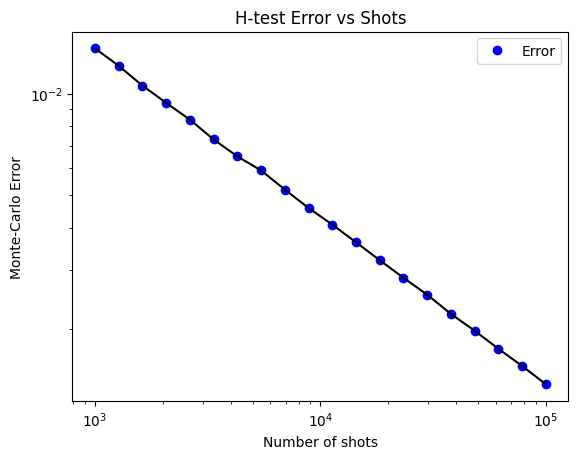

In [30]:
plt.loglog(trials, errorHS, 'bo', label = 'Error')
plt.loglog(trials, errorHS, 'k-')
plt.title("H-test Error vs Shots")
plt.xlabel("Number of shots")
plt.ylabel("Monte-Carlo Error")
plt.legend(loc='upper right')
plt.show()

## Hadamard Test Quantum Computer <a name="HTqc"></a>

## Quantum Phase Estimation Simulation <a name="QPEsim"></a>

## Quantum Phase Estimation Quantum Computer <a name="QPEqc"></a>